# Avi Skidelsky
# Qianwen Liu

# DAV-6150 Module 7 Assignment

In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

In [46]:
%matplotlib inline

# Introduction

The problem that we are tasked with in this scenario is interpretting for an insurance company whether a customer is likely to purchase an additional insurance product. We are going to perform a few binary logistic regression models to try and see which set of variables will give us the best ability to predict this. In the data, we have variables like customer age, city, amount of money spent, type of contract, and various others. This includes our variable that we are trying to predict, TARGET. First importing the data, the size is approximately 14,000 rows and 15 attributes, 14 if you want to only consider the predictive variables.

1.   ID: Unique customer identifier
2.   TARGET: Indicator of buying the new product (0=no, 1=yes)
3.   Loyalty: Loyalty level, from low to high (0 to 3), 99 = unclassified
4.   Age: Age in years
5.   City: Unique code per city
6.   Age_p: Age of partner in years
7.   LOR: Length of relationship in months
8.   LOR_m: Length of relationship in months
9.   Prod_A: Bought product A (0=no, 1=yes)
10.  Type_A: Type of product A
11.  Turnover_A: Amount of money spent on product A
12.  Prod_B: Bought product B (0=no, 1=yes)
13.  Type_B: Type of product B
14.  Turnover_B: Amount of money spent on product B
15.  Contract: Type of contract



# EDA:


In [47]:
raw = pd.read_csv('https://raw.githubusercontent.com/askidelsky/DAV-6150/main/Homework/Module%207/M7_Data.csv')
raw.head()

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
0,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
1,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
2,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
3,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
4,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3


In [48]:
raw.shape

(14016, 15)

###Data Profiling
Looking at the data, it consists of approximately 14,000 observations, each with 15 columns, 14 attributes.

Inspecting the data types of all columns, they are all numeric with the exception of TARGET which is listed as either Y or N. This is fine as we are trying to predict Y vs N and this is easily converted into a simple 1 or 0 value. This change will take place in the data preparation stage. Note that with the exception of age, LOR, turnover_A, turnover_B, age_P, and lor_M, all are categorical variables both ordinal and nominal. Those previously mentioned are the only continuous ones.

In [49]:
raw.dtypes

TARGET         object
loyalty         int64
ID              int64
age             int64
city            int64
LOR             int64
prod_A          int64
type_A          int64
type_B          int64
prod_B          int64
turnover_A    float64
turnover_B    float64
contract        int64
age_P           int64
lor_M           int64
dtype: object

Next, looking at the amount of missing values, thankfully there are none so no imputations will be needed.


In [50]:
raw.isna().sum().sum()

0

### Data Contents and Structure

I decided to check the data for attributes with little to no variance, signaling that they won't impact the result of the model, at least not strongly. One column that is easy to eliminate off the bat is contract. Contract can be eliminated because every observation in this data set has the same value. This signals that the response variable, TARGET, does not change based on whatever this value is at least in the data provided. These steps will be taken care of in the data preparation step.

ID in theory should be unique to each observation but I decided to check anyways. In this case, there are 3,000 rows, amounting to 21.5% of all observations, that are complete duplicates. If it was a smaller percentage of observations then we wouldn't bother eliminating because it wouldn't have much of an effect but here we have no choice but to eliminate the duplicates. This will be taken care of in the data preparation step.

In [51]:
raw[raw.duplicated()==True]

,TARGET,loyalty,ID,age,city,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,contract,age_P,lor_M
11008,Y,99,77,66,2,0,0,0,0,0,333.561114,264.721010,2,66,3
11009,Y,1,159,45,2,3,1,3,3,1,394.735699,284.904978,2,45,39
11010,Y,1,220,42,2,2,1,3,6,1,342.180990,1175.589721,2,42,27
11011,Y,99,303,31,2,0,0,0,0,0,453.757916,242.341754,2,31,3
11012,Y,99,306,62,2,0,0,0,0,0,384.577469,287.008370,2,62,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14011,Y,99,151601,30,2,0,0,0,0,0,386.434278,284.309508,2,30,3
14012,Y,1,151634,27,2,2,1,3,3,1,376.842591,266.993794,2,27,27
14013,Y,99,151679,26,2,0,0,0,0,0,434.805703,284.629361,2,26,3
14014,Y,1,151804,75,2,1,1,3,3,1,366.273857,270.573265,2,75,15


In [52]:
1 - len(raw.ID.unique())/len(raw.ID)

0.21461187214611877

In [53]:
cols = raw[['type_A','type_B','contract']]

vals={}
for i in range(len(cols.columns)):
  vals[cols.columns[i]] = cols.iloc[:,i].unique()
vals

{'contract': array([2]),
 'type_A': array([0, 3, 6]),
 'type_B': array([0, 3, 6, 9])}

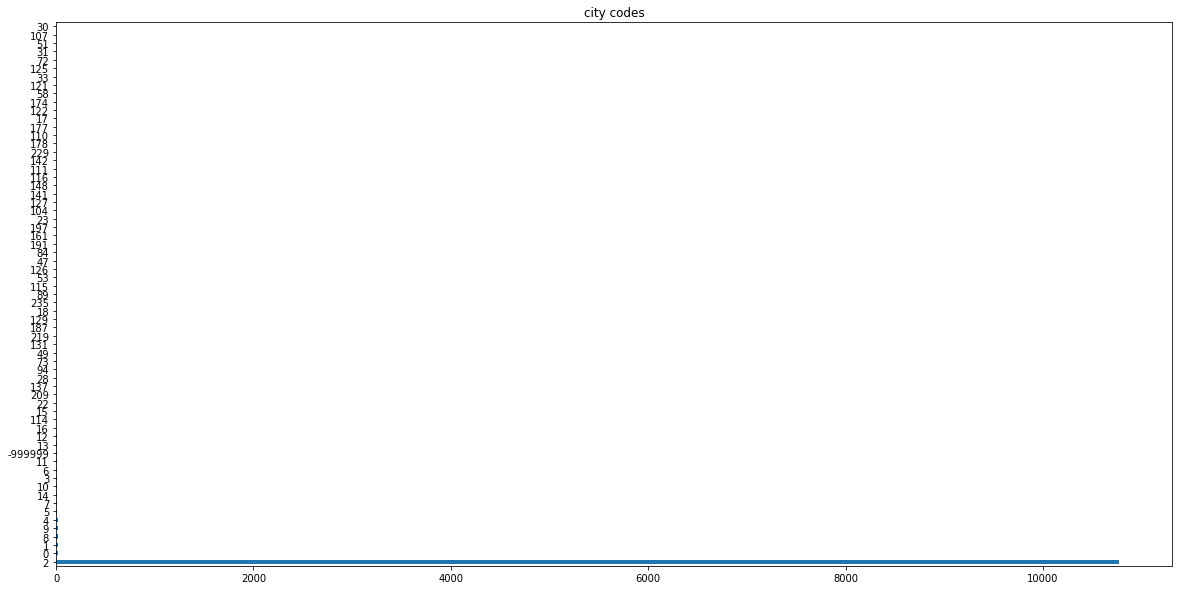

In [129]:
raw['city'].value_counts().plot(kind='barh', figsize=(20,10), title='city codes')

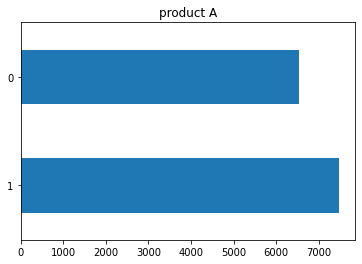

In [55]:
raw['prod_A'].value_counts().plot(kind='barh', title='product A')

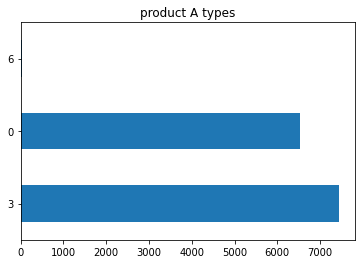

In [56]:
raw['type_A'].value_counts().plot(kind='barh', title='product A types')

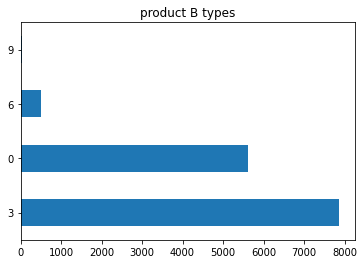

In [57]:
raw['type_B'].value_counts().plot(kind='barh', title='product B types')

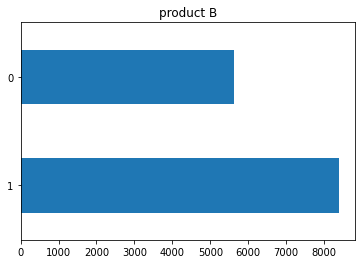

In [58]:
raw['prod_B'].value_counts().plot(kind='barh', title='product B')

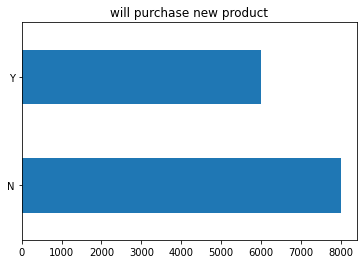

In [59]:
raw['TARGET'].value_counts().plot(kind='barh', title='will purchase new product')

Based on the bar charts above, we can see that they all have enough of a spread of values that they should be considered significant moving forward with the exception of city. While there is variance, an overwhelming majority of the observations are associated with the code "2". I decided to isolate the observations where city code is "2" below and checked out the same distributions of the variables that I did for the data set at large. After examination, they are nearly identical which leads me to believe that city isn't significant and can be removed. This is helpful going forward as we would need to create over 50 dummy variables if we had included it. This change will be reflected in the data preparation step.

As for the response variable, we aren't able to visualize an obvious trend in the target variable at a quick glance so the logistic regression is in fact necessary to glean knowledge from this data set.

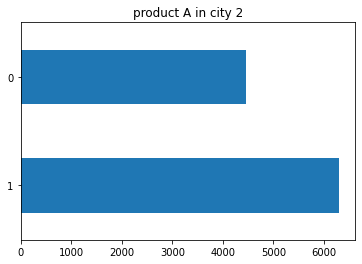

In [130]:
city = raw[raw.city==2]
city['prod_A'].value_counts().plot(kind='barh', title='product A in city 2')

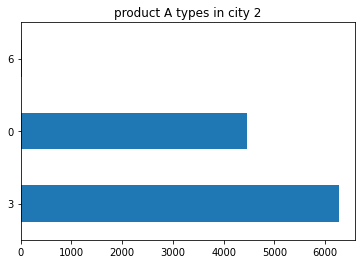

In [131]:
city['type_A'].value_counts().plot(kind='barh', title='product A types in city 2')

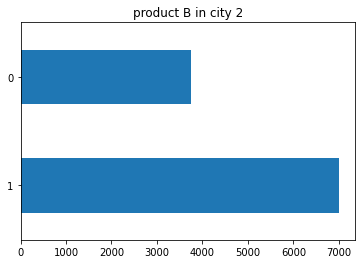

In [133]:
city['prod_B'].value_counts().plot(kind='barh', title='product B in city 2')

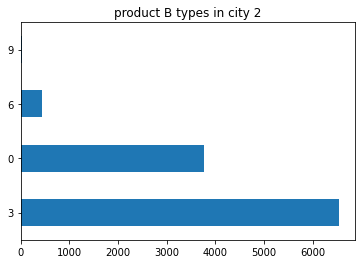

In [134]:
city['type_B'].value_counts().plot(kind='barh', title='product B types in city 2')

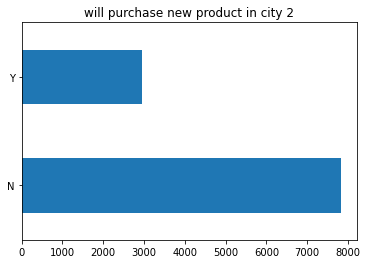

In [135]:
city['TARGET'].value_counts().plot(kind='barh', title='will purchase new product in city 2')

Looking at these histograms describing the continuous distributions, a lot of these results are easily interpretable by considering the characteristics of each observation. For example, turnover_A and turnover_B are largely skewed to one value. A simple explanation for this is that products are typically the same price, although this isn't always true based on some other factors considered by the insurance underwriters which explains the small amount of data that is represented as other values.

age_P, the age of the other member of the insurance policy is skewed towards dependents in their 30s with the next highest values coming in around the 20s although it is noted that the skew isn't as heavy as other distributions. A possible explanation is that typically dependents on policies are spouses or children which explains the ages. age and age_P follow almost identical distributions, seeing as typically spouses who share the policy are roughly similar ages. 

What is surprising is looking at the describe box, the lowest value for age is five, what five year old has their own insurance policy? This is likely an outlier or an error on input. However, looking at the histogram for age, the count of those values is so minimal that it isn't even appearing as visual on the chart, only 7 observations amounting to only 0.05% of the overall data. An explanation for this is if a parent buys a plan for just the child for one reason or another. Looking at the boxplots below however, there are a significant amount of outliers and I don't want to shy away from them since there are significant amount of them for each attribute. 

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f60bff86590>,
      dtype=object)

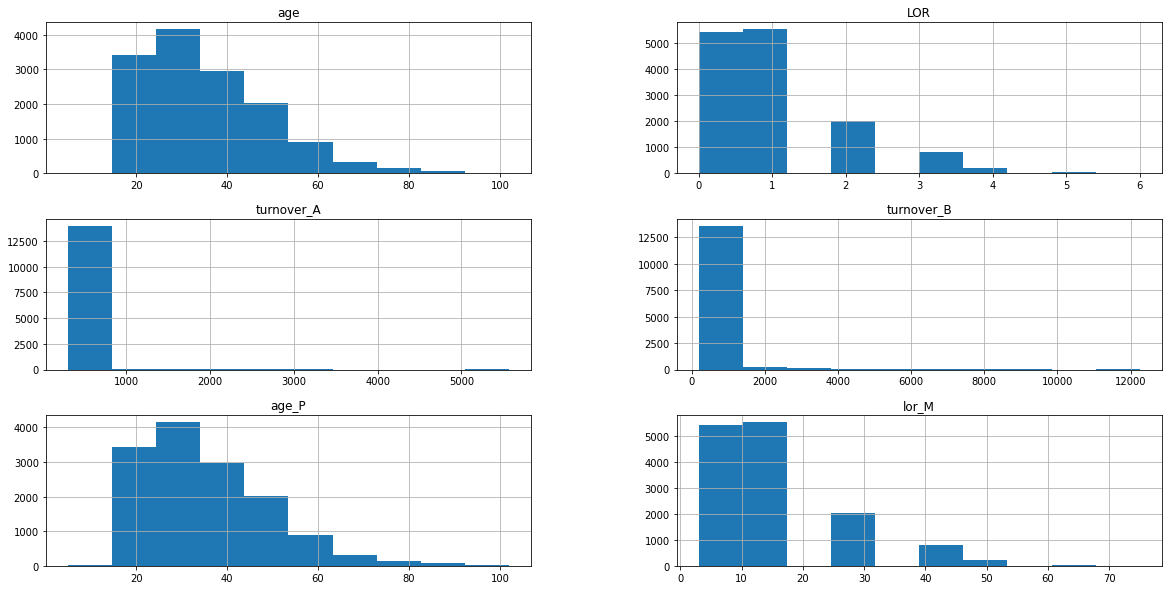

In [65]:
nums = raw[['age','LOR','turnover_A','turnover_B','age_P','lor_M']]
nums.hist(figsize=(20,10))

In [66]:
nums.describe()

,age,LOR,turnover_A,turnover_B,age_P,lor_M
count,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000,14016.000000
mean,35.882920,0.926299,379.161320,328.628207,35.882920,14.115582
std,12.974634,0.965212,92.612207,475.616525,12.974634,11.582550
min,5.000000,0.000000,300.095909,191.962852,5.000000,3.000000
25%,25.000000,0.000000,334.919412,219.406925,25.000000,3.000000
50%,33.000000,1.000000,367.891493,237.656757,33.000000,15.000000
75%,43.000000,1.000000,399.744924,264.131538,43.000000,15.000000
max,102.000000,6.000000,5568.784139,12249.084770,102.000000,75.000000


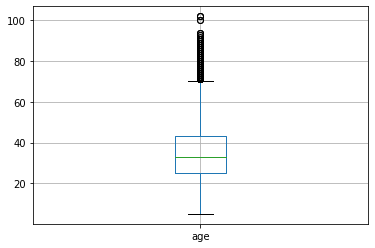

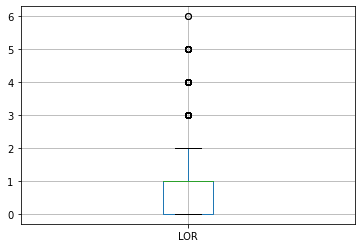

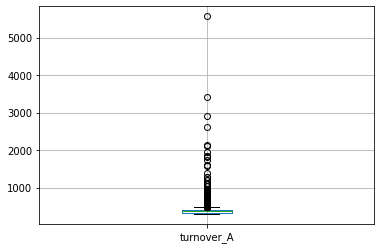

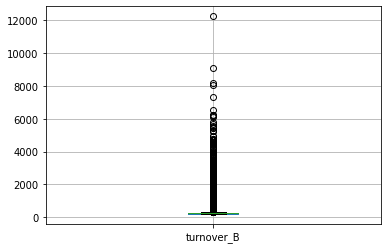

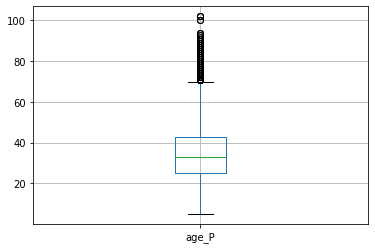

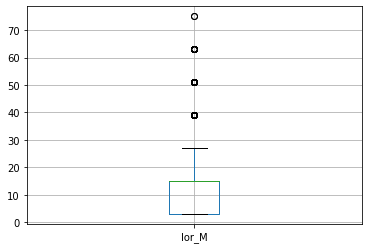

In [67]:
for column in nums:
  plt.figure()
  nums.boxplot([column])

To examine any more variables before creating tons of dummies, we will check out a correlation matrix to see if there may be colinearity. There are two concerns of multicolinearity between age and age_P and LOR and lor_M. Neither age or age_P will be eliminated at this point since they are describing two different aspects of each observation. However, the connection between LOR and lor_M is concerning since LOR is essentially just lor_M divided by 12, length being expressed in years instead of months. I don't think that it's necessary to include both of these and since I want to preserve both possible relationships, I will remove LOR since lor_M encompasses both pieces of information on a more granular level while LOR only expresses one piece of information on a very general sense. This change will occur in data preparation.

In [68]:
nums.corr()

,age,LOR,turnover_A,turnover_B,age_P,lor_M
age,1.000000,0.089640,0.135887,0.251625,1.000000,0.089640
LOR,0.089640,1.000000,0.009987,0.158571,0.089640,1.000000
turnover_A,0.135887,0.009987,1.000000,0.128613,0.135887,0.009987
turnover_B,0.251625,0.158571,0.128613,1.000000,0.251625,0.158571
age_P,1.000000,0.089640,0.135887,0.251625,1.000000,0.089640
lor_M,0.089640,1.000000,0.009987,0.158571,0.089640,1.000000


# Data Preparation

### Removing Variables

As mentioned in steps above, ID, city, and contract can be eliminated because they provide no new information for each observation after we eliminated all duplicates. ID is unique to every observation that will ever come in and contract is a constant value of "2". City can be dropped because even though not all observations are of the same value, an overwhelming majority of them are and by using city and creating over 50 dummy variables, we would be introducing a lot of unnecessary noise.

In [69]:
raw= raw.drop_duplicates(subset=['ID'])
1 - len(raw.ID.unique())/len(raw.ID)

0.0

In [70]:
clean = raw.drop(columns=['ID', 'contract', 'city']).copy()
clean.head()

,TARGET,loyalty,age,LOR,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,age_P,lor_M
0,Y,99,66,0,0,0,0,0,333.561114,264.721010,66,3
1,Y,1,45,3,1,3,3,1,394.735699,284.904978,45,39
2,Y,1,42,2,1,3,6,1,342.180990,1175.589721,42,27
3,Y,99,31,0,0,0,0,0,453.757916,242.341754,31,3
4,Y,99,62,0,0,0,0,0,384.577469,287.008370,62,3


Also mentioned above, LOR and lor_M have too strong of a connection to both be included and if both are included, will likely introduce a lot of unnecessary noise and multicollinearity. For this reason, I decided to remove LOR since lor_M encompasses all of the information.

In [71]:
clean.drop(columns='LOR', inplace=True)
clean.head()

,TARGET,loyalty,age,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,age_P,lor_M
0,Y,99,66,0,0,0,0,333.561114,264.721010,66,3
1,Y,1,45,1,3,3,1,394.735699,284.904978,45,39
2,Y,1,42,1,3,6,1,342.180990,1175.589721,42,27
3,Y,99,31,0,0,0,0,453.757916,242.341754,31,3
4,Y,99,62,0,0,0,0,384.577469,287.008370,62,3


### Variable Manipulation

A binary dummy variable needed to be added to the data to replace the target variable since the target variable was listed as a simple Y or N and the model can't take that. The target column can be dropped after this step as it would be redundent to include it in the data set now that we have a simplified version of it.

In [72]:
clean['purchase'] = (clean.TARGET=='Y').astype(int)
clean.drop(columns='TARGET', inplace=True)
clean.head()

,loyalty,age,prod_A,type_A,type_B,prod_B,turnover_A,turnover_B,age_P,lor_M,purchase
0,99,66,0,0,0,0,333.561114,264.721010,66,3,1
1,1,45,1,3,3,1,394.735699,284.904978,45,39,1
2,1,42,1,3,6,1,342.180990,1175.589721,42,27,1
3,99,31,0,0,0,0,453.757916,242.341754,31,3,1
4,99,62,0,0,0,0,384.577469,287.008370,62,3,1


### Feature Engineering

Even though all values are listed as integers, type_A, type_B, and loyalty are all categorical and should be treated as any other categorical value. For this reason, dummy variables need to be created based off of them. This leaves us with 20 variables to possibly include. This number will be reduced after performing some further review.

In [73]:
clean_1 = pd.get_dummies(clean, columns=['loyalty','type_A','type_B'], drop_first=False)
clean_1.head()

,age,prod_A,prod_B,turnover_A,turnover_B,age_P,lor_M,purchase,loyalty_0,loyalty_1,loyalty_2,loyalty_3,loyalty_99,type_A_0,type_A_3,type_A_6,type_B_0,type_B_3,type_B_6,type_B_9
0,66,0,0,333.561114,264.721010,66,3,1,0,0,0,0,1,1,0,0,1,0,0,0
1,45,1,1,394.735699,284.904978,45,39,1,0,1,0,0,0,0,1,0,0,1,0,0
2,42,1,1,342.180990,1175.589721,42,27,1,0,1,0,0,0,0,1,0,0,0,1,0
3,31,0,0,453.757916,242.341754,31,3,1,0,0,0,0,1,1,0,0,1,0,0,0
4,62,0,0,384.577469,287.008370,62,3,1,0,0,0,0,1,1,0,0,1,0,0,0


In [74]:
clean_1.shape

(11008, 20)

# Prepped Data Review

Now that all of data has been transformed and the necessary dummy variables have been created, a good step to start our review is at the correlation matrix. Looking at this revised correlation chart there are a few things that stand out. 

First, none of these features has an extremely high correlation value, even though a significant amount of them have decent numbers. This could indicate that more variables are required to put together a strong model.

What is a little bit confusing are a few of the variables that are negatively correlated. For example, the highest level of loyalty has the highest level of correlation out of all levels and yet it's negatively correlated. This goes against conventional knowledge that the customer who is more loyal would buy more products.

While none of these variables have particularly amazing correlation values, I do see some of them as potentially being good predictors. Therefore based on this, one of the methods that I will be using is a correlation threshold for feature selection.

In [75]:
corr = clean_1.corr()
corr['purchase'].sort_values(ascending=False)

purchase      1.000000
type_B_0      0.316734
type_A_0      0.293210
loyalty_99    0.228532
age           0.227510
age_P         0.227510
turnover_A    0.201813
type_A_6      0.003193
type_B_9     -0.026166
loyalty_0    -0.043847
loyalty_1    -0.047778
loyalty_2    -0.054305
turnover_B   -0.084418
type_B_6     -0.084766
lor_M        -0.171396
loyalty_3    -0.175314
type_B_3     -0.271626
prod_A       -0.293210
type_A_3     -0.293296
prod_B       -0.316734
Name: purchase, dtype: float64

In [76]:
corr

,age,prod_A,prod_B,turnover_A,turnover_B,age_P,lor_M,purchase,loyalty_0,loyalty_1,loyalty_2,loyalty_3,loyalty_99,type_A_0,type_A_3,type_A_6,type_B_0,type_B_3,type_B_6,type_B_9
age,1.000000,-0.140526,-0.038487,0.130944,0.293546,1.000000,0.120313,0.227510,-0.070481,0.176724,0.142065,-0.172700,-0.066388,0.140526,-0.140334,-0.000983,0.038487,-0.136908,0.228266,0.058666
prod_A,-0.140526,1.000000,0.865835,0.000495,-0.029556,-0.140526,0.558389,-0.293210,0.057712,0.201052,0.138672,0.395625,-0.592269,-1.000000,0.995711,0.038588,-0.865835,0.784853,0.139205,0.029384
prod_B,-0.038487,0.865835,1.000000,-0.016728,0.148441,-0.038487,0.734568,-0.316734,0.049531,0.315490,0.215316,0.397294,-0.729080,-0.865835,0.862121,0.033411,-1.000000,0.909723,0.151093,0.040039
turnover_A,0.130944,0.000495,-0.016728,1.000000,0.138260,0.130944,0.024052,0.201813,-0.018607,0.070925,0.021966,-0.068654,-0.006800,-0.000495,-0.000342,0.009035,0.016728,-0.019888,0.009333,-0.002020
turnover_B,0.293546,-0.029556,0.148441,0.138260,1.000000,0.293546,0.164561,-0.084418,-0.016236,0.098606,0.179842,0.002766,-0.188478,0.029556,-0.028874,-0.007131,-0.148441,-0.055078,0.455100,0.133092
age_P,1.000000,-0.140526,-0.038487,0.130944,0.293546,1.000000,0.120313,0.227510,-0.070481,0.176724,0.142065,-0.172700,-0.066388,0.140526,-0.140334,-0.000983,0.038487,-0.136908,0.228266,0.058666
lor_M,0.120313,0.558389,0.734568,0.024052,0.164561,0.120313,1.000000,-0.171396,0.001321,0.542256,0.210861,0.101552,-0.640154,-0.558389,0.554773,0.034731,-0.734568,0.581869,0.296721,0.126605
purchase,0.227510,-0.293210,-0.316734,0.201813,-0.084418,0.227510,-0.171396,1.000000,-0.043847,-0.047778,-0.054305,-0.175314,0.228532,0.293210,-0.293296,0.003193,0.316734,-0.271626,-0.084766,-0.026166
loyalty_0,-0.070481,0.057712,0.049531,-0.018607,-0.016236,-0.070481,0.001321,-0.043847,1.000000,-0.033889,-0.024824,-0.040774,-0.065809,-0.057712,0.057973,-0.003272,-0.049531,0.054778,-0.014797,-0.003921
loyalty_1,0.176724,0.201052,0.315490,0.070925,0.098606,0.176724,0.542256,-0.047778,-0.033889,1.000000,-0.164530,-0.270242,-0.436163,-0.201052,0.195776,0.055424,-0.315490,0.247190,0.127874,0.077060


In [77]:
clean_1.drop(columns='age_P', inplace=True)

# Regression Modeling

Moving on to some feature selection to fit our model, a common method is principal component analysis but in this situation it isn't a good fit. PCA is only good for numeric variables and in our data set as it stands, there are only a couple of variables and they are similar in nature. My strategy for selecting best model is to test three different feature selection methods to see which comes up with the best selection of attributes for our model. Since we are trying to predict the number of customers who will buy the extra package to be used for marketing purposes, we would rather predict more yesses and market to customers that will not buy the package than to miss potential sales opportunities. Therefore, we will be judging the models based on recall/sensitivity. Before moving to any of these methods, we need to split the data into two sets, the X consisting of all predictive attributes and y consisting of just the response variable. In order to interpret the results of the logistic regression best, we also have to flatten the y variable into 1D arrays after splitting into training and test sets.

In [117]:
X = clean_1.drop('purchase', axis=1)
y = clean_1[['purchase']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

y_train = np.ravel(y_train)
y_test = np.ravel(y_test)

In [100]:
X_train.shape

(8806, 18)

In [119]:
model = LogisticRegression()
model.fit(X_train, y_train)
predicted = model.predict(X_test)
a = metrics.classification_report(y_test, predicted)
print(a)

              precision    recall  f1-score   support

           0       0.82      0.94      0.87      1601
           1       0.73      0.44      0.55       601

    accuracy                           0.80      2202
   macro avg       0.77      0.69      0.71      2202
weighted avg       0.79      0.80      0.78      2202



/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


I created an initial model consisting of all variables included to compare against. By definition, this model is overfit and has high variance so it will be useful to have these statistics in determining the best model, seeing if we could get close to these numbers without using nearly as many variables. A key metric to pay attention to is the f-1 score. The f-1 score is an enhanced version of the accuracy giving weight to lower measures to show how well the model really performs. With this control, the f-1 is 78% which is pretty good. We will look at all measures but in particular the f-1.

### First Method/Model

My first theory to test when creating my model is that maybe the potential customer can't be identified by any numeric statistics like age, length of relationship, or amount paid. Maybe, the key to identifying the perfect customer is through past activity. To test this theory, I decided to create a model of just those variables, including the various types, loyalty levels, and product types. 

In [120]:
from sklearn.metrics import recall_score
X_train1 = X_train[['type_B_0', 'type_B_0','loyalty_99','loyalty_0','loyalty_1','loyalty_2','type_B_6','loyalty_3','type_A_3','type_B_3','prod_A','prod_B']]
X_test1 = X_test[['type_B_0', 'type_B_0','loyalty_99','loyalty_0','loyalty_1','loyalty_2','type_B_6','loyalty_3','type_A_3','type_B_3','prod_A','prod_B']]

model1 = LogisticRegression()
model1.fit(X_train1, y_train)
predicted = model1.predict(X_test1)
b = metrics.classification_report(y_test, predicted)
print(b)

              precision    recall  f1-score   support

           0       0.73      0.99      0.84      1601
           1       0.17      0.00      0.01       601

    accuracy                           0.72      2202
   macro avg       0.45      0.50      0.42      2202
weighted avg       0.57      0.72      0.61      2202



Looking at the output of this model, it underperforms significantly compared to the statistics of our control model. All of the key measures are down and comparing the f-1 metric to the control, it's down 17% in this case. This isn't the best model to present. 

### Second Method/Model



The next method of feature selection that we decided to test is using the extra trees classifier. This selector fits a number of randomized decision trees on various subsamples of the data and uses averaging to improve accuracy and reduce over-fitting. Here, the classifier gives us age, turnover_A, and turnover_B as the variables to use in our prediction.

In [104]:
clf = ExtraTreesClassifier()
clf = clf.fit(X_train, y_train)
model=SelectFromModel(clf, prefit=True)
feature_idx=model.get_support()
feature_name = X_train.columns[feature_idx]
feature_name

Index(['age', 'turnover_A', 'turnover_B'], dtype='object')

In [121]:
X_train2 = X_train[['age','turnover_A','turnover_B']]
X_test2 = X_test[['age','turnover_A','turnover_B']]

model2 = LogisticRegression()
model2.fit(X_train2, y_train)
predicted = model2.predict(X_test2)
c = metrics.classification_report(y_test, predicted)
print(c)

              precision    recall  f1-score   support

           0       0.78      0.94      0.86      1601
           1       0.67      0.30      0.41       601

    accuracy                           0.77      2202
   macro avg       0.73      0.62      0.63      2202
weighted avg       0.75      0.77      0.74      2202



Using the features selected by this model, although only being 3 features, we are able to get extremely close to our control model with the f-1 score only going down by 4% and the other metrics follow a similar pattern. So far, this model seems to work best. Interestingly enough since it has only 3 variables but it was selected using statistical means and not human intuition so that probably has something to do with it.

### Third Method/Model

The third method of feature selection being used is setting a correlation threshold. As mentioned above and displayed below, none of the variables has particularly high correlation so the threshold being set is going to be fairly low, in this case 25%. That left us with just type_B_0, type_A_0, type_B_3, prod_A, type_A_3, and prod_B. As shown below, all of these values have high correlation with each other but that's understood if you examine the variables chosen. All of these are binary variables and at least when it comes to the dummies of the product type variables, if an observation shows 0 for one of them then that means one of the others will be a 1. Given these understandable connections, we don't need to be worried about multicolinearity.

In [110]:
corr = clean_1.corr()
corr['purchase'].sort_values(ascending=False)

purchase      1.000000
type_B_0      0.316734
type_A_0      0.293210
loyalty_99    0.228532
age           0.227510
turnover_A    0.201813
type_A_6      0.003193
type_B_9     -0.026166
loyalty_0    -0.043847
loyalty_1    -0.047778
loyalty_2    -0.054305
turnover_B   -0.084418
type_B_6     -0.084766
lor_M        -0.171396
loyalty_3    -0.175314
type_B_3     -0.271626
prod_A       -0.293210
type_A_3     -0.293296
prod_B       -0.316734
Name: purchase, dtype: float64

In [111]:
X_train3.corr()

,type_B_0,type_A_0,type_B_3,prod_A,prod_B
type_B_0,1.000000,0.866369,-0.911339,-0.866369,-1.000000
type_A_0,0.866369,1.000000,-0.787243,-1.000000,-0.866369
type_B_3,-0.911339,-0.787243,1.000000,0.787243,0.911339
prod_A,-0.866369,-1.000000,0.787243,1.000000,0.866369
prod_B,-1.000000,-0.866369,0.911339,0.866369,1.000000


In [107]:
corr = clean_1.corr()['purchase'].sort_values(ascending=False)
vals = []
for i in range(len(corr)):
  if abs(corr[i]) < 1 and abs(corr[i]) > 0.25:
    vals.append(corr.index[i])

vals

['type_B_0', 'type_A_0', 'type_B_3', 'prod_A', 'type_A_3', 'prod_B']

In [124]:
X_train3 = X_train[['type_B_0','type_A_0','type_B_3','prod_A','prod_B']]
X_test3 = X_test[['type_B_0','type_A_0','type_B_3','prod_A','prod_B']]

model3 = LogisticRegression()
model3.fit(X_train3, y_train)
predicted = model3.predict(X_test3)
d = metrics.classification_report(y_test, predicted)
print(d)

              precision    recall  f1-score   support

           0       0.73      1.00      0.84      1601
           1       0.00      0.00      0.00       601

    accuracy                           0.73      2202
   macro avg       0.36      0.50      0.42      2202
weighted avg       0.53      0.73      0.61      2202



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Looking at this output, these scores resemble those that we saw in the second model. This isn't surprising as all of these variables were included in the first model and are all categorical.

# Model Selection

After looking at the three models generated, it's clear that the one that comes closest to the control model is the second, with features generated by using the extra trees classifier. Compared to the other two models, it is the only one that incorporates all numeric values but what is interesting is that it contains two variables that are just the price of packages A and B which is something that I would not have considered to put in. Another reason to choose this model is because it has potential to get better. It's pretty close to the model that was overfit and could be enhanced by adding one or two categorical variables to the equation.

In [127]:
print('Control', a)
print('Model #2', c)

Control               precision    recall  f1-score   support

           0       0.82      0.94      0.87      1601
           1       0.73      0.44      0.55       601

    accuracy                           0.80      2202
   macro avg       0.77      0.69      0.71      2202
weighted avg       0.79      0.80      0.78      2202

Model #2               precision    recall  f1-score   support

           0       0.78      0.94      0.86      1601
           1       0.67      0.30      0.41       601

    accuracy                           0.77      2202
   macro avg       0.73      0.62      0.63      2202
weighted avg       0.75      0.77      0.74      2202



As seen in the outputs above, the numbers of the second model and the control look nearly identical when fitted.

# Conclusion
It seems that when it comes to logistic regression, at least in this scenario, the best route to feature selection is through statistical methods. When broken down mathematically, just correlation threshold and intuition are not enough to generate the perfect model. In terms of feature engineering, interaction variables might be a better route to go instead of just using binary and dummie variables. For example in this scenario, instead of having a column for products a and b as binaries, we could have created an interaction variable called "products owned", this would be a continuous numerical variable that in this caes would consist of values from 0-2. 